# US & International News Discussions 
# Web API & NLP with Classification Models

---

### Contents:

1. [Problem Statement](#Problem-Statement:)
2. [Selected Data for Analysis](#Selected-Data-for-Analysis)
3. [Data and Library Imports](#Imported-Libraries)
4. [Data Cleaning](#Data-Cleaning)
5. [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis)
6. [Preprocessing & Modeling](#Preprocessing-&-Modeling)
7. [Evaluation of Models](#Evaluation-of-Models)
8. [Conclusion & Recommendations](#Conclusion-&-Recommendations)
9. [Citations](#Citations)

---

### Problem Statement:

The United States possesses over 312 million internet users who produce the vast majority of the content consumed by the entire 4.93 billion people that have access to the web. This, in partnership with the United States' existing and elevated position on world interests, represents an evolving and potentially vulnerable domain. 

Allowing and displaying open access to American political discourse is, in turn, having a direct impact on international news, discussion, and the contextual understanding of the U.S. position is within the worldwide web. As the internet continues to evolve, how will online discussions within the United States shape the evolving sentiments and ideas of the international community? In particular, what topics in US discourse carry the most influence 
on the global political discussion?

### Selected Data for Analysis:

The following project utilized data pulled from the featured subreddits:

**/r/politics** <br>[U.S. News/Political Disucssion](https://www.reddit.com/r/politics/)<br>
News and discussion about U.S. politics (7.8 million members).


**/r/worldnews** <br> [International News/Political Discussion](https://www.reddit.com/r/worldnews/)<br>
News and discussion about international political interests (27.2 million members).

### Imported Libraries:

In [516]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2_unweighted
from matplotlib import style

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import re
import sys
import requests
import time
import datetime 


pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

### Imported Data

To import the desired and appropriate amount of data per the problem statement, web scrapping is conducted using Python's request library.`requests.get` simplifies HTTP requests to streamline the collection of data. Pushshift Reddit API further enhances the ability to search, access, aggregate, and analyze data from Reddit's massive collection of online communities. Lastly,`.json` is key to collecting and presenting the desired data by means of reformatting.

**Subreddit URLs / Subreddits:**

In [177]:
submissions_url = 'https://api.pushshift.io/reddit/search/submission?'
comments_url = 'https://api.pushshift.io/reddit/search/comment/?'

subreddits = ['politics', 'worldnews']

**For-Loops Used to Scrape Text Data from Subreddits:**

In [178]:
# SUBMISSIONS TEXT REQUEST:

# The sub_loop collects data pulled from each request of submissions
sub_loop = []

# Creating a for loop to run requests
for submission in subreddits:
    
    # running 20 requests pulling 100 submissions each time
    for i in range(20):
        
        # Parameters that guide the request
        params = {
            'subreddit': subreddits,
            'size': 100 } # Max allowed
        
        # Set to pull new data with each request
        if i != 0:
            params['before'] = close
        
        res = requests.get(submissions_url, 
                           params = params)
        
        # JSON used to store and transmit dataa from webpages
        data = res.json()
        
        # Converting posts to dataframe and selecting desired columns
        posts = pd.DataFrame(data['data'])
        posts = posts[['subreddit', 'title', 'created_utc']]
        
        # Marks end of request 
        close = posts['created_utc'].values[-1]
        
        # Adding collected data.
        sub_loop.append(posts)
        
        # Setting sleep time between requests
        time.sleep(3)

# Concatenating collected data.
submissions_df = pd.concat(sub_loop)

submissions_df['content'] = submissions_df['title']
submissions_df.drop(columns = ['title'], inplace = True)


# UTILIZING SIMILIAR FOR LOOP AS ABOVE TO COLLECT COMMENT DATA FROM SUBREDDITS

comm_loop = []

for comments in subreddits:
    
    for i in range(20):
        
        params = {
            'subreddit': subreddits,
            'size': 100 } # Max allowed
        
        if i != 0:
            params['before'] = cut
            
        res = requests.get(comments_url, 
                           params = params)
        data = res.json()
        comms = pd.DataFrame(data['data'])
        comms = comms[['subreddit', 'body', 'created_utc']]
        
        cut = comms['created_utc'].values[-1]
        
        comm_loop.append(comms)
        
        time.sleep(3)
    
comments_df = pd.concat(comm_loop)

comments_df['content'] = comments_df['body']
comments_df.drop(columns = ['body'], inplace = True)


df = pd.concat([submissions_df, comments_df])

df.reset_index(inplace = True)
df.drop(columns = ['index'], inplace = True)

#df.to_csv('data/project_raw.csv')

df

,subreddit,created_utc,content
0,politics,1637442322,"From Kenosha riots to Kyle Rittenhouse trial, ..."
1,politics,1637442316,"No one talks about it anymore, but people in E..."
2,politics,1637442108,Right-Wingers Turn on Glenn Youngkin Over His ...
3,worldnews,1637442034,"No jab, no job: Why Chantal has chosen to quit..."
4,worldnews,1637441877,Kizz Daniel - Eh God (Barnabas)
...,...,...,...
7989,politics,1637439347,"i would, too. She's having a grand ole time g..."
7990,politics,1637439347,Bullshit
7991,politics,1637439342,They already know what do blame when they inev...
7992,politics,1637439341,[removed]


### Data Cleaning

The standard process of collecting raw data and preparing it for EDA by addressing any existing null/missing values, outliers, errors, and negative influence on data comprehension. 

Unique to Natural Language Processing (NLP) is the need to implement `wnl.lemmatize()`. The World Net Lemmatizer is a large lexical database for the English language that identifies structured semantic relationships between words. This helps to increase the precision of the data cleaning, EDA, and modeling. Regular Expression (regex) is also used in partnership with NLP and the featured data cleaning function below. Regex sequences are unique patterns of characters that work to isolate specified textual features.

In [4]:
#df = pd.read_csv('data/project_raw.csv')

**Converting UTC Epoch time to UTC Datetime:**

In [179]:
df['created_utc'] = pd.to_datetime(df['created_utc'], unit = 's')

**Converting 'subreddit' Column to Binary:**

In [180]:
df['subreddit'] = df['subreddit'].map({'politics': 0, 'worldnews': 1})

df.rename(columns = {'subreddit': 'world_news'}, inplace = True)

**Function used to addressing basic problems accossiated with web-scraped data:**

In [182]:
wnl = WordNetLemmatizer()

def data_cleaning(text):
    
    # Converting text to lowercase to allow for easier/faster cleaning
    text = text.lower()
    
    # Removes whitespace that can cause errors in analysis
    text = re.sub(r'\s\s+', ' ', text)  
    
    # Removes all HTML problems
    text = re.sub(r'\&\w*;', '', text) 
    
    # Removes hyperlinks 
    text = re.sub(r'https?:\/\/.*\/\w*', '', text)
    
    # Spltting string into list to enable lemmatizer
    words = text.split()

    word_loop = []

    for word in words: 
        
        # Lemmatization convers word to base form, allowing for more acurate analysis
        i = wnl.lemmatize(word)
        word_loop.append(i)      

    # Putting cleaned textual data together    
    output = ' '.join(word_loop)

    return output 

# Insert the df 'content' column into function - "function is a higher class citizen"
df['content'] = df['content'].apply(data_cleaning)

df.head()

,world_news,created_utc,content
0,0,2021-11-20 21:05:22,"from kenosha riot to kyle rittenhouse trial, b..."
1,0,2021-11-20 21:05:16,"no one talk about it anymore, but people in ea..."
2,0,2021-11-20 21:01:48,right-winger turn on glenn youngkin over his l...
3,1,2021-11-20 21:00:34,"no jab, no job: why chantal ha chosen to quit ..."
4,1,2021-11-20 20:57:57,kizz daniel - eh god (barnabas)


In [184]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7994 entries, 0 to 7993
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   world_news   7994 non-null   int64         
 1   created_utc  7994 non-null   datetime64[ns]
 2   content      7994 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 187.5+ KB


In [185]:
df.isnull().sum()

world_news     0
created_utc    0
content        0
dtype: int64

In [186]:
#df.to_csv('data/project_cleaned.csv')

### Exploratory Data Analysis

Returning focus to the problem statement that guides the analysis, the featured EDA works to present and study a variety of statistical perspectives. The primary objective is to identify key trends/influences within the data that will serve both the predictive model and a meaningful solution.

Count Vectorizer from the sk.learn library helps provide an extension to the EDA by converting the textual strings into a matrix of integers. This helps to enable the use of visualization to examine the data.

In [ ]:
#df = pd.read_csv('data/project_cleaned.csv')

**Creating Dataframe for Sources from /r/worldnews:**

In [187]:
world_only = df.loc[df['world_news'] == 1]

world_df = pd.DataFrame(world_only)

**Creating Dataframe for Sources from /r/politics:**

In [517]:
us_only = df.loc[df['world_news'] == 0]

us_df = pd.DataFrame(us_only)

**Count Vectorizer to Guide EDA:**

In [189]:
cvec = CountVectorizer(stop_words = 'english', 
                       max_df = .90, # Max % of Data Text May Appear in
                       min_df = 10) # Min number of text frequency in data

#### Analyzing Top 50 Words of Entire Data Frame:

In [430]:
content = df['content']

# Count Vectorizing df for word frequency analysis
cvec.fit(content)

content_cvec = cvec.transform(content)

# Converting to df
content_df = pd.DataFrame(content_cvec.todense(),
                          columns = cvec.get_feature_names())

#content_df.to_csv('data/eda_df_cvec.csv')

In [431]:
top_content = content_df.sum(axis=0)

top_content.sort_values(ascending = False).head(50)

rittenhouse    1159
people          959
kyle            892
wa              749
guilty          603
just            558
biden           499
like            470
don             451
white           441
ha              432
say             424
right           416
removed         330
time            324
charge          312
think           305
kenosha         279
make            275
trump           273
shooting        268
year            261
china           247
state           247
republican      245
thing           234
black           232
want            231
know            223
way             214
need            205
did             200
country         195
going           194
law             194
verdict         190
house           189
live            189
trial           188
jury            182
covid           180
police          175
men             172
new             169
case            167
isn             165
point           162
count           161
news            158
said            155


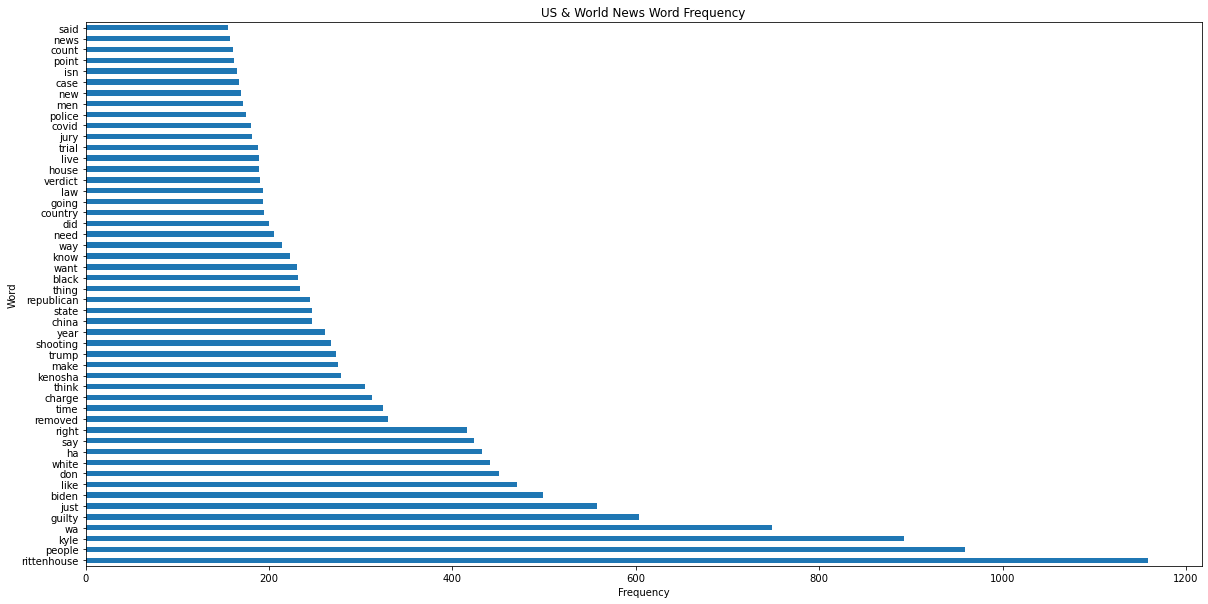

In [465]:
top_content.sort_values(ascending=False).head(50).plot(kind = 'barh', figsize = (20, 10))

plt.title('US & World News Word Frequency')
plt.xlabel('Frequency')
plt.ylabel('Word');

#plt.savefig('visuals/df_top_50_barh')

In [433]:
# Creating df of top 50 words to more easily isolate key trends for greater EDA.
df_top_content = top_content.to_frame(name = 'count')

df_top_content['word'] = df_top_content.index

df_top_content.reset_index(drop = True, inplace = True)

df_top_content['frequency (%)'] = df_top_content['count'] / len(df) * 100



# Setting up the df 
cols = ['word', 'count', 'frequency (%)']

df_top_content = df_top_content[cols]

df_top_content.sort_values(by = 'count',
                           ascending = False,
                           inplace = True)

df_top_content.head()

,word,count,frequency (%)
1331,rittenhouse,1159,14.498374
1125,people,959,11.996497
877,kyle,892,11.158369
1657,wa,749,9.369527
714,guilty,603,7.543157


#### Analyzing Top 50 Words of International News:

In [434]:
world_content = world_df['content']

# Count Vectorizing world news df for word frequency analysis
cvec.fit(world_content)

world_cvec = cvec.transform(world_content)

# Converting to df
worldnews_df = pd.DataFrame(world_cvec.todense(),
                            columns = cvec.get_feature_names())

worldnews_df.to_csv('data/eda_worldnews_cvec.csv')

In [194]:
top_world = worldnews_df.sum(axis = 0)

top_world.sort_values(ascending = False).head(50)

china          221
people         200
say            149
covid          142
just           123
wa             114
ha             106
russia         106
don            106
like           101
market          98
country         92
year            90
world           86
rittenhouse     84
kyle            80
chinese         75
know            74
new             72
make            72
2021            72
law             69
india           68
police          67
government      65
removed         64
protest         60
live            58
time            56
want            56
video           56
look            56
peng            54
news            54
state           53
right           51
shuai           50
guilty          50
child           49
farm            48
charge          48
day             47
19              46
tennis          46
austria         44
need            43
use             42
group           42
germany         42
home            42
dtype: int64

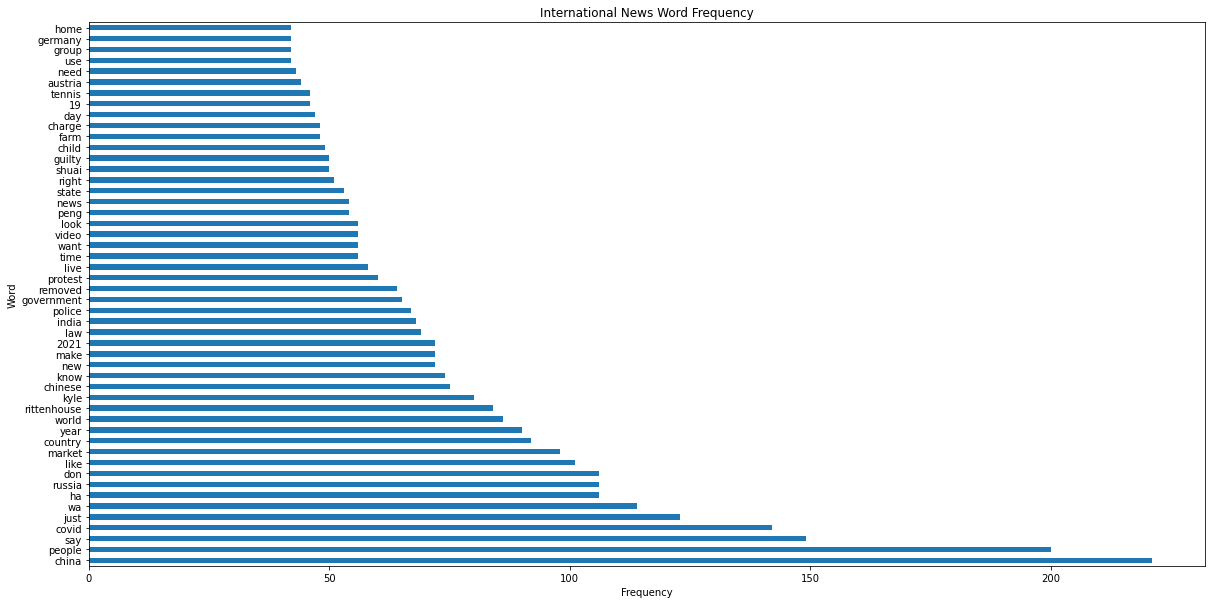

In [466]:
top_world.sort_values(ascending=False).head(50).plot(kind = 'barh', figsize = (20, 10))

plt.title('International News Word Frequency')
plt.xlabel('Frequency')
plt.ylabel('Word');

#plt.savefig('visuals/world_top_50_barh')

In [196]:
df_top_world = top_world.to_frame(name = 'count')

df_top_world['word'] = df_top_world.index

df_top_world.reset_index(drop = True, inplace = True)

df_top_world['frequency (%)'] = df_top_world['count'] / len(world_df) * 100



cols = ['word', 'count', 'frequency (%)']

df_top_world = df_top_world[cols]

df_top_world.sort_values(by = 'count',
                           ascending = False,
                           inplace = True)

df_top_world.head()

,word,count,frequency (%)
82,china,221,8.801274
336,people,200,7.964954
397,say,149,5.933891
107,covid,142,5.655117
241,just,123,4.898447


#### Analyzing Top 50 Words of US News:

In [435]:
us_content = us_df['content']

# Count Vectorizing U.S. news df for word frequency analysis
cvec.fit(us_content)

us_cvec = cvec.transform(us_content)

usnews_df = pd.DataFrame(us_cvec.todense(),
                         columns = cvec.get_feature_names())

usnews_df.to_csv('data/eda_usnews_cvec.csv')

In [198]:
top_usnews = usnews_df.sum(axis = 0)

top_usnews.sort_values(ascending = False).head(50)

rittenhouse    1075
kyle            812
people          759
wa              635
guilty          553
biden           459
just            435
white           423
like            369
right           365
don             345
ha              326
say             275
time            268
removed         266
think           265
charge          264
trump           259
shooting        248
kenosha         245
republican      237
black           212
make            203
state           194
thing           194
verdict         184
want            175
way             174
did             174
year            171
jury            168
house           164
trial           162
need            162
men             154
going           153
democrat        149
know            149
point           148
case            147
angry           145
count           144
gun             140
isn             139
actually        135
gop             133
vote            133
racist          131
live            131
man             127


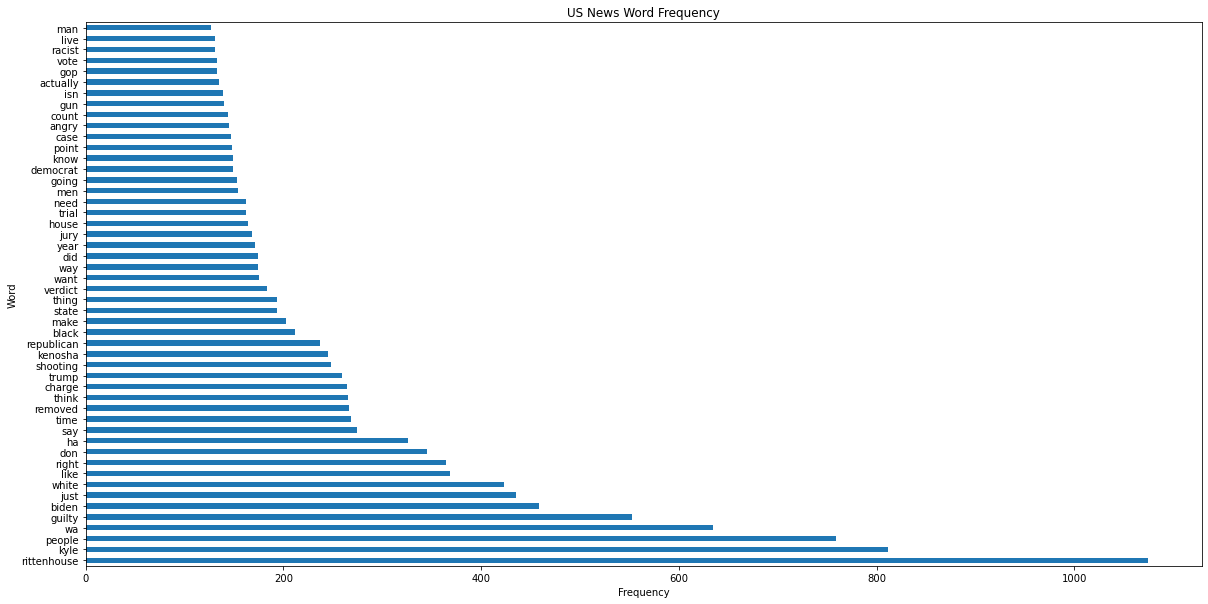

In [467]:
top_usnews.sort_values(ascending=False).head(50).plot(kind = 'barh', figsize = (20, 10))

plt.title('US News Word Frequency')
plt.xlabel('Frequency')
plt.ylabel('Word');

#plt.savefig('visuals/us_top_50_barh')

In [200]:
df_top_usnews = top_usnews.to_frame(name = 'count')

df_top_usnews['word'] = df_top_usnews.index

df_top_usnews.reset_index(drop = True, inplace = True)

df_top_usnews['frequency (%)'] = df_top_usnews['count'] / len(us_df) * 100



cols = ['word', 'count', 'frequency (%)']

df_top_usnews = df_top_usnews[cols]

df_top_usnews.sort_values(by = 'count',
                           ascending = False,
                           inplace = True)

df_top_usnews.head()

,word,count,frequency (%)
976,rittenhouse,1075,19.606055
639,kyle,812,14.809411
819,people,759,13.842787
1216,wa,635,11.581251
518,guilty,553,10.085719


#### Comparisson Analysis of International & US News Word Frequency:

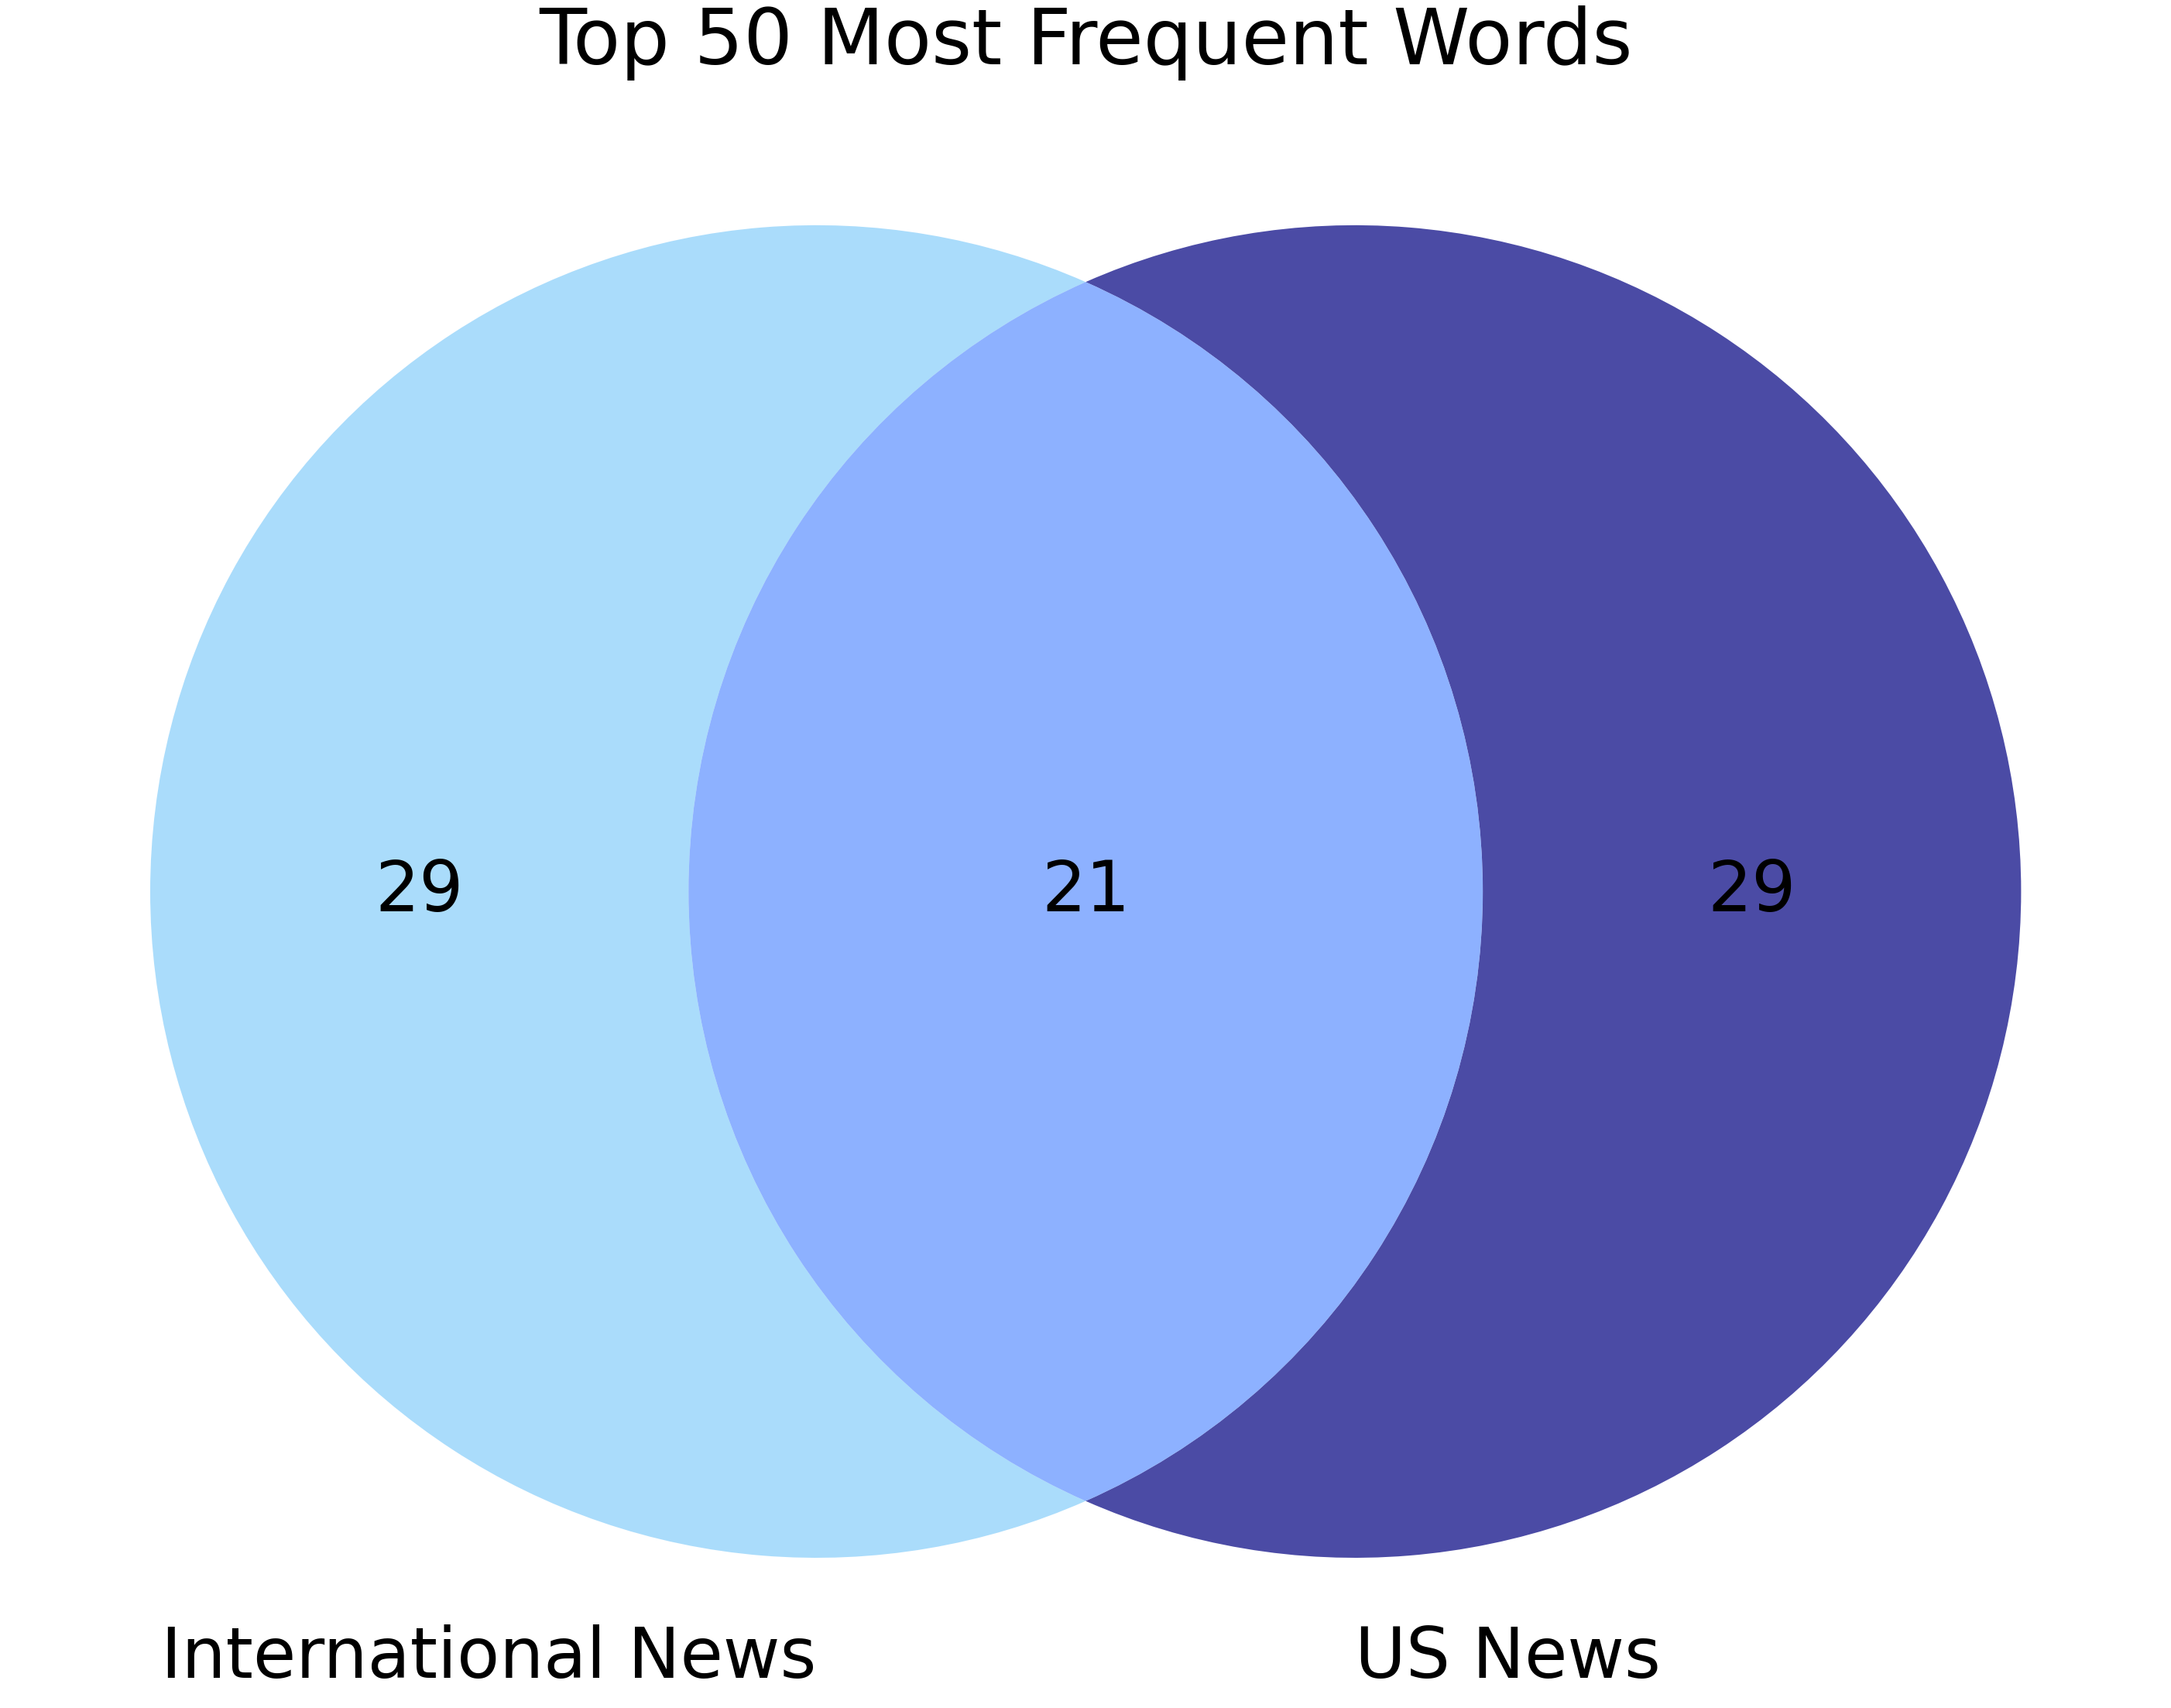

In [468]:
# Venn Diagaram

# Data for Venn Diagram
world_words = set(df_top_world['word'][:50])
us_words = set(df_top_usnews['word'][:50])

plt.figure(figsize = (50, 50))

v1 = venn2_unweighted(subsets = (world_words, us_words),
                 set_labels = ('International News', 'US News'),
                 set_colors = ('lightskyblue', 'navy'),
                 alpha = 0.7)

plt.title('Top 50 Most Frequent Words', fontsize = 100);

for text in v1.set_labels:
    text.set_fontsize(90)
    
for text in v1.subset_labels:
    text.set_fontsize(90)
    
#plt.savefig('visuals/venn_top_50_numerical')

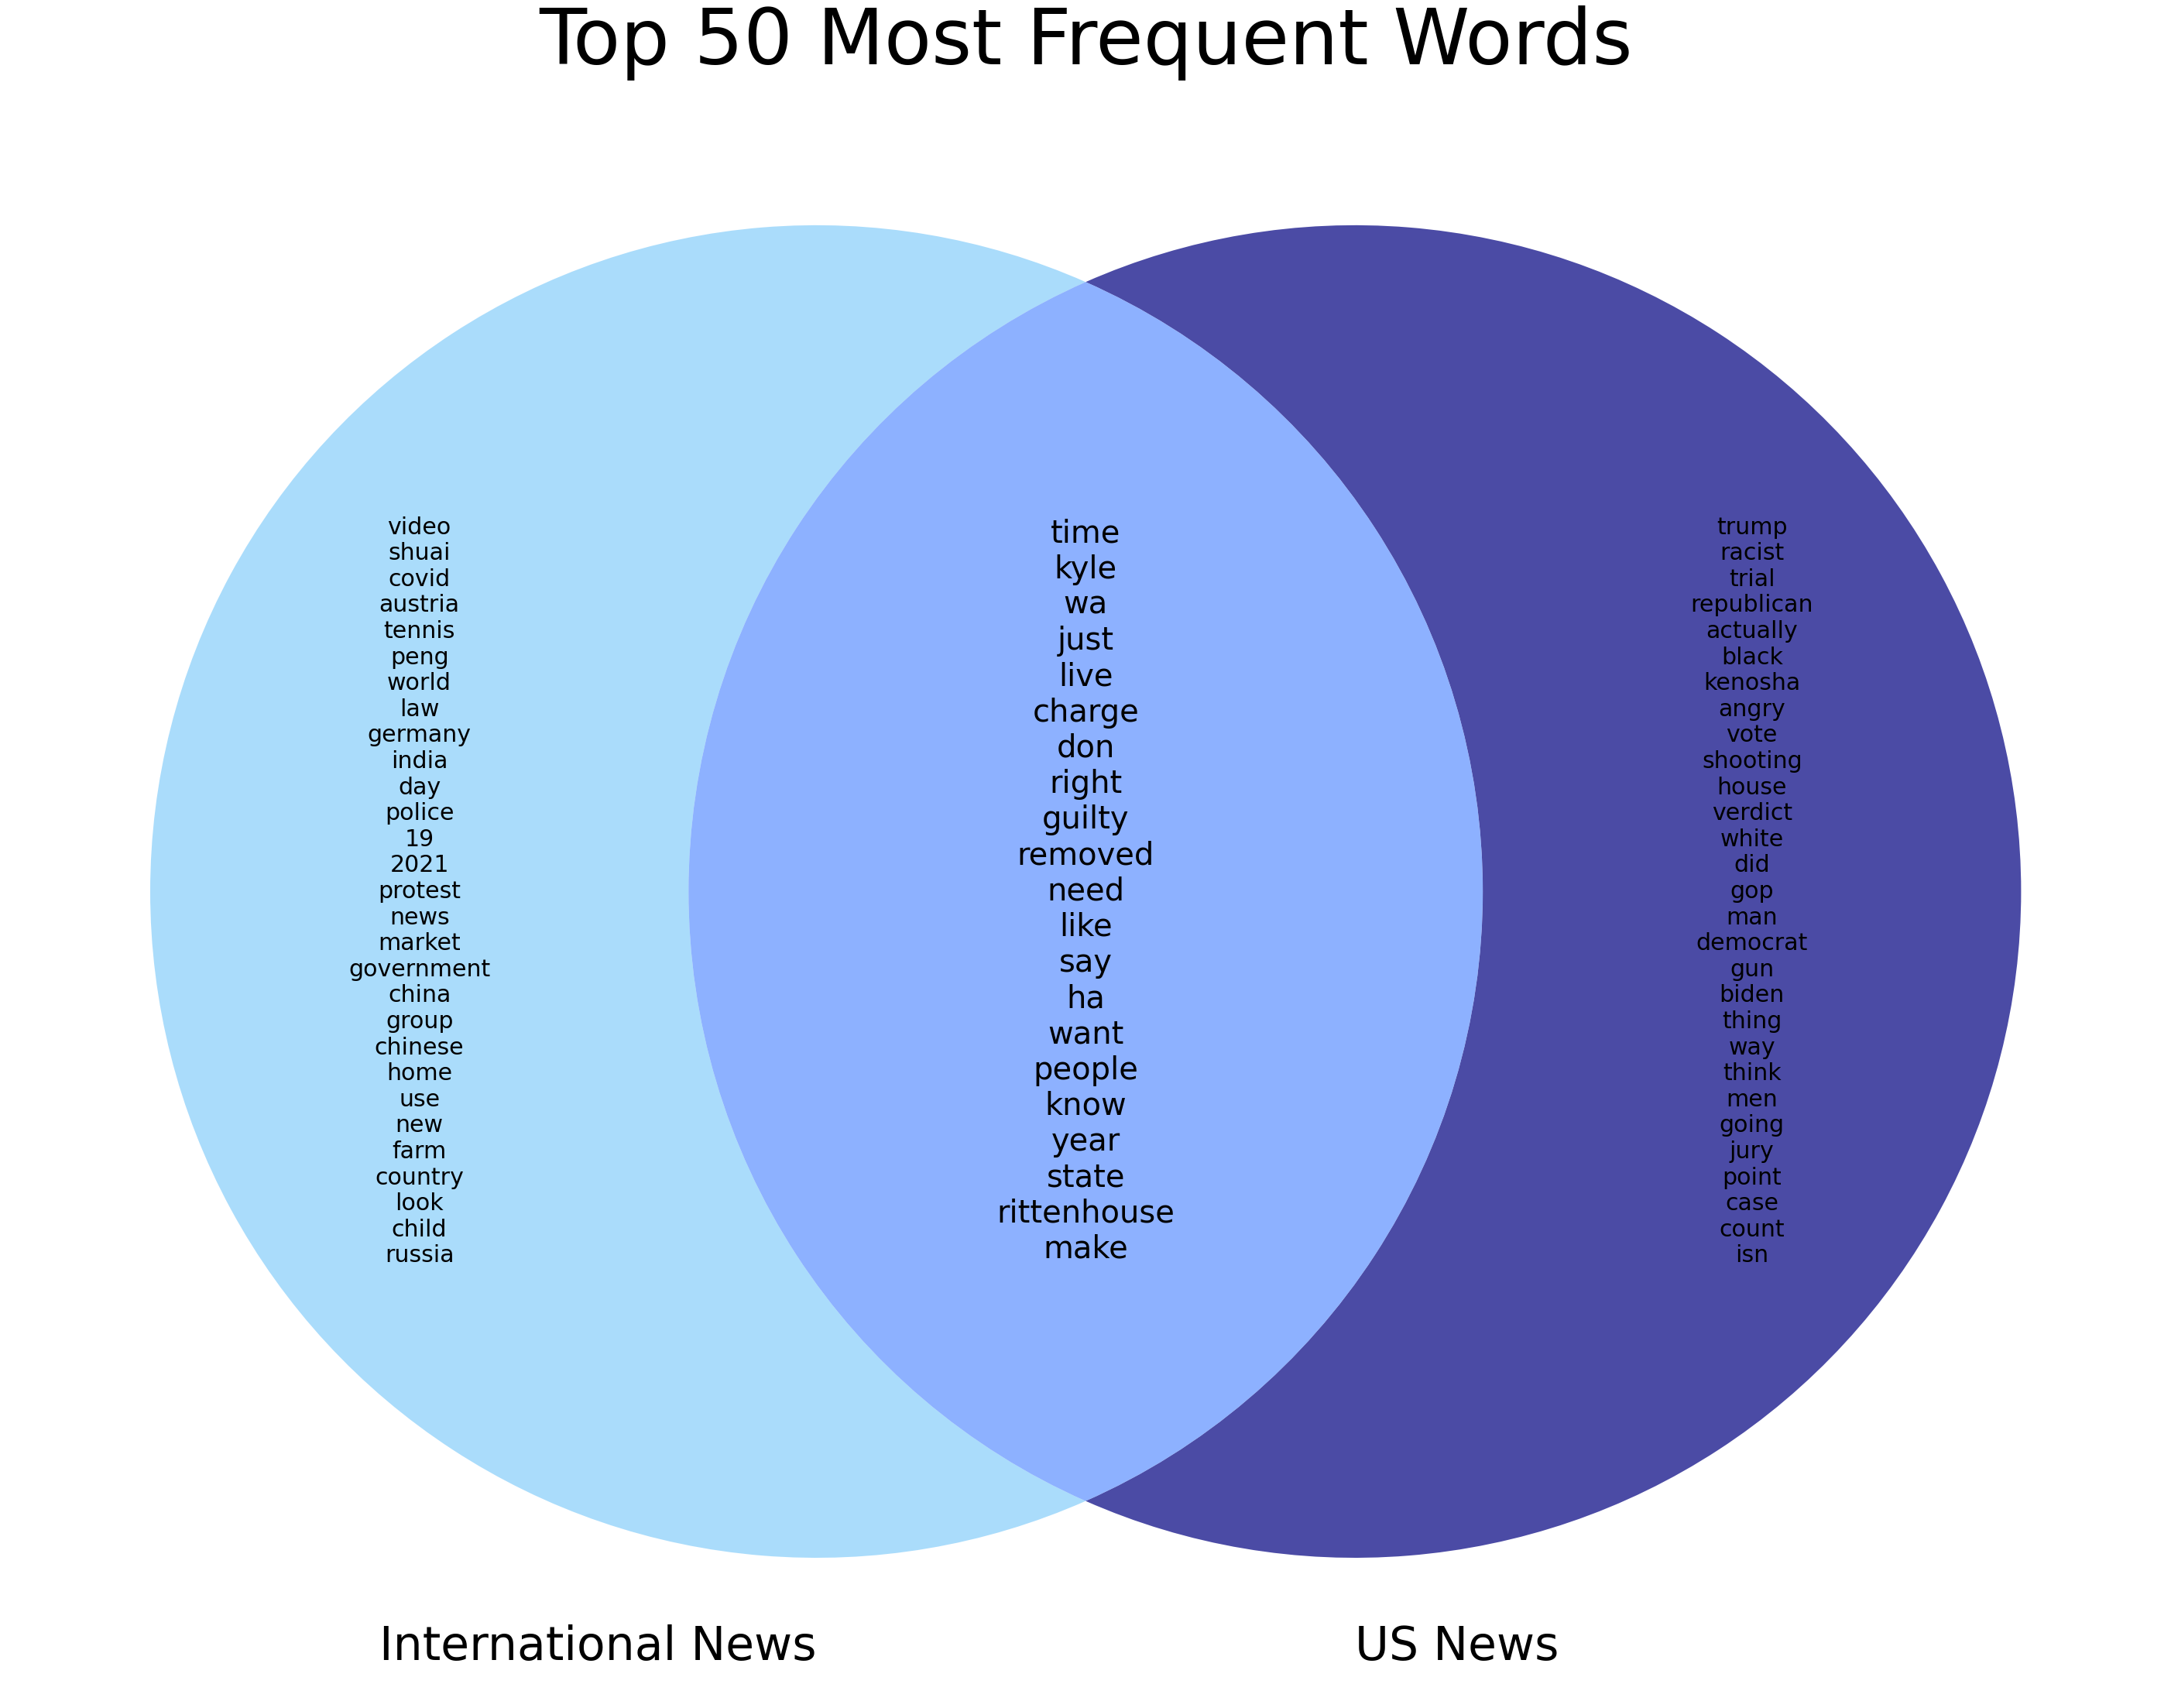

In [469]:
#Venn Diagram

# Data for Venn Diagram
world_words = set(df_top_world['word'][:50])
us_words = set(df_top_usnews['word'][:50])

plt.figure(figsize = (50, 50))

v = venn2_unweighted(subsets = (world_words, us_words),
                 set_labels = ('International News', 'US News'),
                 set_colors = ('lightskyblue', 'navy'),
                 alpha = 0.7)

plt.title('Top 50 Most Frequent Words', fontsize = 100);
v.get_label_by_id('A').set_size(60)
v.get_label_by_id('B').set_size(60)

# Left circle representing those only in world news df
v.get_label_by_id('100').set_text('\n'.join(map(str, world_words - us_words)))
v.get_label_by_id('100').set_size(30)

# Right circle representing those only in us news df
v.get_label_by_id('010').set_text('\n'.join(map(str, us_words - world_words)))
v.get_label_by_id('010').set_size(30)

# Union of us and and world news df top 50 words
v.get_label_by_id('110').set_text('\n'.join(map(str, world_words & us_words)))
v.get_label_by_id('110').set_size(40)

#plt.savefig('visuals/venn_top_50_text')

#### Sentiment Analysis of Dataframe:

In [207]:
positive_words = ['awesome', 'calm', 'clean', 'energetic', 'good', 'great', 'happy', 'hope', 'kindness', 'peace']

negative_words = ['anger', 'bad', 'depressed', 'horrible', 'injustice', 'lost', 'pain', 'sad', 'violence', 'war']

In [208]:
sia = SentimentIntensityAnalyzer()

def sentiment_id(text):
    
    # Uses regex to parse string into multiple tokens
    tokenizer = RegexpTokenizer(r'\w+')

    # Lower case allows for easier targeting of textual data
    tokens = tokenizer.tokenize(text.lower())
    
    # Used to find root stem of words 
    p_stemmer = PorterStemmer()

    # List compression to guide stemming
    stemmed_words = [p_stemmer.stem(t) for t in tokens]
 
    positive_stems = [p_stemmer.stem(t) for t in positive_words]
    negative_stems = [p_stemmer.stem(t) for t in negative_words]

    # Collecting sentiment analysis counts to direct scoring 
    positive_count = sum([1 for t in stemmed_words if t in positive_stems])
    negative_count = sum([1 for t in stemmed_words if t in negative_stems])

    # Return percentage score
    return (positive_count - negative_count) / len(stemmed_words)

In [209]:
# Converting column data to sting to enable the use of sentiment_id function
content_text = [text for text in df['content']]

content_string = ' '.join(map(str, content_text))

sentiment_id(content_string)

-9.213034140049635e-05

In [210]:
# Converted to df for later use.
content_s = pd.DataFrame([sia.polarity_scores(content_string)])

content_s

,neg,neu,pos,compound
0,0.159,0.707,0.133,-1.0


In [211]:
# Converting column data to sting to enable the use of sentiment_id function
world_text = [text for text in world_df['content']]

world_string = ' '.join(map(str, world_text))

sentiment_id(world_string)

-2.3101090371465534e-05

In [212]:
# Converted to df for later use.
world_s = pd.DataFrame([sia.polarity_scores(world_string)])

world_s

,neg,neu,pos,compound
0,0.158,0.723,0.119,-1.0


In [213]:
# Converting column data to sting to enable the use of sentiment_id function
us_text = [text for text in us_df['content']]

us_string = ' '.join(map(str, us_text))

sentiment_id(us_string)

-0.00011504920270902523

In [214]:
# Converted to df for later use.
us_s = pd.DataFrame([sia.polarity_scores(us_string)])

us_s

,neg,neu,pos,compound
0,0.162,0.703,0.135,-1.0


In [215]:
# Setting up df of sentiment analysis
content_s['sources'] = 'US / International'

world_s['sources'] = 'International Only'

us_s['sources'] = 'US Only'

sentiment_df = pd.concat([content_s, world_s, us_s])

sentiment_df.set_index('sources', 
                       inplace = True)

sentiment_df

,neg,neu,pos,compound
sources,,,,
US / International,0.159,0.707,0.133,-1.0
International Only,0.158,0.723,0.119,-1.0
US Only,0.162,0.703,0.135,-1.0


#### Summary Statistics:

- The entire data frame represents 7,994 entries with there being a slightly greater number of U.S. sourced discussion text. 
- 21 of the top 50 words for each subreddit were the same. All 21 alluded to U.S. domestic activity.
- All 50 most frequent words in U.S. focused subreddit were used in a discussion of matters regarding domestic instability. 
- International text frequencies highlight interest in injustice and exterior political influence with significant discussion being had over China and Russia.
- Sentiment Analysis identified data frames as having -1.0 compound score. Though the majority of the text was determined to be neutral, the bias towards negative sentiment is distinguishable. 

---

### Preprocessing & Modeling

After EDA, preprocessing & modeling occur working on identified trends and influences. In working with NLP, text data is converted to matrix representation to be used by the classification models. Stop words, stemming, and lemmatization further optimize the predictive ability of the classifiers.

Separate of actions unique to when working with NLP, the standard operation of `train_test_split()` and testing/evaluating a variety of models. 

**Assigning X and y feature:**

In [276]:
X = df['content']
y = df['world_news'] # Target data

**Baseline Score**

In [277]:
y.value_counts(normalize=True) # Baseline score of 0.314

0    0.685889
1    0.314111
Name: world_news, dtype: float64

**Spliting Data Into Train and Test:**

In [356]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42, 
                                                    stratify=y)

#### K Nearest Neighhbor (KNN) Classification Model (Count Vectorizer):

Utilizes ‘feature similarity’ to predict the values of new datapoints. Model is being produced with a Pipeline, GridSeachCV, and the CountVectorizer.

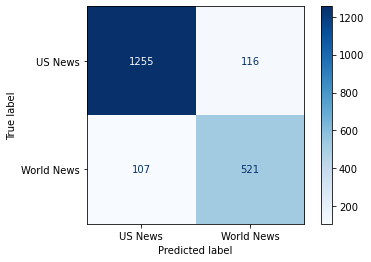

In [470]:
#Pipeline enables easy and fluid direction of model preprocessors for application.
knn_model = Pipeline([
    ('cvec', CountVectorizer()), # Vectorizer
    ('knn', KNeighborsClassifier()) # Model
])

# Params set using .best_params_ and GA Lecture + Notes examples.

knn_params = {
    'cvec__min_df': [8, 9, 10],
    'cvec__max_df': [.1, .2, .3],
    'cvec__binary': [True, False],
    'cvec__stop_words': [None, 'english'],
    'knn__weights': ['uniform', 'distance'] 
}

# GS evaluates and optimizes model parameters 
knn_gs = GridSearchCV(knn_model, 
                      param_grid = knn_params)

knn_gs.fit(X_train, y_train)

metrics.plot_confusion_matrix(knn_gs, X_test, y_test, 
                              display_labels = ['US News', 'World News'],
                              cmap = 'Blues')

#plt.savefig('visuals/knn_matrix')

> **KNN (Count Vectorizer) Evaluation:**

In [510]:
knn_preds = knn_gs.predict(X_test)
knn_tn, knn_fp, knn_fn, knn_tp = metrics.confusion_matrix(y_test, knn_preds).flatten()

knn_acc = (knn_tn + knn_tp) / (knn_tn + knn_fp + knn_fn + knn_tp)
knn_spec = knn_tn / (knn_tn + knn_fp)
knn_sens = knn_tp / (knn_tp + knn_fn)
knn_prec = knn_tp / (knn_tp + knn_fp)
knn_f1 = metrics.f1_score(y_test, knn_preds)

knn_bs = knn_gs.best_score_

print("\nAccuracy: ", knn_acc) # Most important metric
print("Specificity: ", knn_spec) # Prediction of U.S. discussion text.
print("Sensitivity: ", knn_sens) # Prediction of international discussion text.                      
print("Precision: ", knn_prec)
print("F1 Score:", knn_f1) # Considers both precision and recall


Accuracy:  0.8884442221110556
Specificity:  0.9153902261123268
Sensitivity:  0.8296178343949044
Precision:  0.8178963893249608
F1 Score: 0.8237154150197629


#### Logistic Regression Classification Model (TF-IDF):

Regression classification model that evaluates variety of variables to produce predicted binary outcome. Model is being produced with a Pipeline, GridSeachCV, and the TF_IDF Vectorizer.

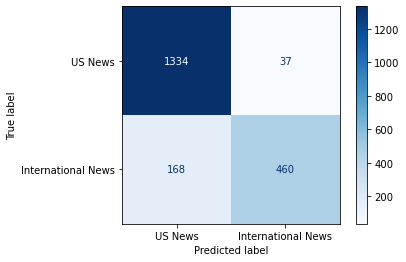

In [471]:
#Pipeline enables easy and fluid direction of model preprocessors for application.
logreg_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()), # Vectorizer
    ('logreg', LogisticRegression()) # Model
])

# Params set using .best_params_ and GA Lecture + Notes examples.

logreg_params = {
    'tfidf__stop_words': [None, 'english'],
    'tfidf__min_df': [1, 2, 3, 4, 5],
    'tfidf__max_df': [.2, .3, .4],
    'logreg__C': [1, 2, 3]
}

# GS evaluates and optimizes model parameters 
logreg_gs = GridSearchCV(logreg_pipe, 
                         param_grid = logreg_params)

logreg_gs.fit(X_train, y_train)

metrics.plot_confusion_matrix(logreg_gs, X_test, y_test, 
                              display_labels = ['US News', 'International News'],
                              cmap = 'Blues')

#plt.savefig('visuals/logreg_matrix')

> **Logistic Regression (TF-IDF) Evaluation**

In [511]:
logreg_preds = logreg_gs.predict(X_test)
logreg_tn, logreg_fp, logreg_fn, logreg_tp = metrics.confusion_matrix(y_test, logreg_preds).flatten()

logreg_acc = (logreg_tn + logreg_tp) / (logreg_tn + logreg_fp + logreg_fn + logreg_tp)
logreg_spec = logreg_tn / (logreg_tn + logreg_fp)
logreg_sens = logreg_tp / (logreg_tp + logreg_fn)
logreg_prec = logreg_tp / (logreg_tp + logreg_fp)
logreg_f1 = metrics.f1_score(y_test, logreg_preds)

logreg_bs = logreg_gs.best_score_

print("\nAccuracy: ", logreg_acc) # Most important metric
print("Specificity: ", logreg_spec) # Prediction of U.S. discussion text.
print("Sensitivity: ", logreg_sens) # Prediction of international discussion text.                       
print("Precision: ", logreg_prec)
print("F1 Score:", logreg_f1) # Considers both precision and recall


Accuracy:  0.897448724362181
Specificity:  0.9730123997082422
Sensitivity:  0.732484076433121
Precision:  0.9255533199195171
F1 Score: 0.8177777777777777


#### Descion Tree Classification Model (Count Vectorizer)

Evaluates and splits data in binary notes to produce predictions. Model is being produced with a Pipeline, GridSeachCV, and the Count Vectorizer. 

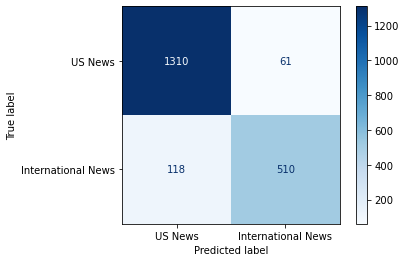

In [472]:
#Pipeline enables easy and fluid direction of model preprocessors for application.
dt_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('dt', DecisionTreeClassifier())
])

dt_params = {
    'cvec__stop_words': [None, 'english'],
    'dt__random_state': [33]
}

# GS evaluates and optimizes model parameters 
dt_gs = GridSearchCV(dt_pipe, 
                     param_grid = dt_params)

dt_gs.fit(X_train, y_train)

metrics.plot_confusion_matrix(dt_gs, X_test, y_test, 
                              display_labels = ['US News', 'International News'],
                              cmap = 'Blues')

#plt.savefig('visuals/dt_matrix')

> **Decision Trees (Count Vectorizer) Evaluation:**

In [512]:
dt_preds = dt_gs.predict(X_test)
dt_tn, dt_fp, dt_fn, dt_tp = metrics.confusion_matrix(y_test, dt_preds).flatten()

dt_acc = (dt_tn + dt_tp) / (dt_tn + dt_fp + dt_fn + dt_tp)
dt_spec = dt_tn / (dt_tn + dt_fp)
dt_sens = dt_tp / (dt_tp + dt_fn)
dt_prec = dt_tp / (dt_tp + dt_fp)
dt_f1 = metrics.f1_score(y_test, dt_preds)

dt_bs = dt_gs.best_score_

print("\nAccuracy: ", dt_acc) # Most important metric
print("Specificity: ", dt_spec) # Prediction of U.S. discussion text.
print("Sensitivity: ", dt_sens) # Prediction of international discussion text.                      
print("Precision: ", dt_prec)
print("F1 Score:", dt_f1) # Considers both precision and recall


Accuracy:  0.9104552276138069
Specificity:  0.9555069292487236
Sensitivity:  0.8121019108280255
Precision:  0.8931698774080561
F1 Score: 0.8507089241034197


#### Random Forest Classificaiton Model (Count Vectorizer):

Produces and combines multiple decision trees by random subspace method. Model is being produced with a Pipeline, GridSeachCV, and the Count Vectorizer.

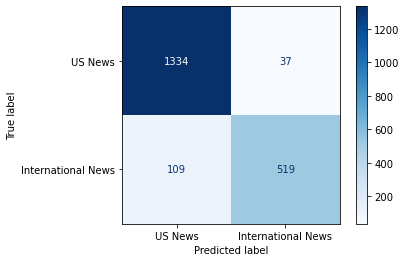

In [487]:
#Pipeline enables easy and fluid direction of model preprocessors for application.
rf_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])
            
rf_params = {
    'cvec__stop_words': [None, 'english'],
    'rf__random_state': [33],
}

# GS evaluates and optimizes model parameters 
rf_gs = GridSearchCV(rf_pipe, 
                     param_grid = rf_params)

rf_gs.fit(X_train, y_train)

metrics.plot_confusion_matrix(rf_gs, X_test, y_test, 
                              display_labels = ['US News', 'International News'],
                              cmap = 'Blues')

#plt.savefig('visuals/rf_matrix')

> **Random Forest (Count Vectorizer) Evaluation:**

In [513]:
rf_preds = rf_gs.predict(X_test)
rf_tn, rf_fp, rf_fn, rf_tp = metrics.confusion_matrix(y_test, rf_preds).flatten()

rf_acc = (rf_tn + rf_tp) / (rf_tn + rf_fp + rf_fn + rf_tp)
rf_spec = rf_tn / (rf_tn + rf_fp)
rf_sens = rf_tp / (rf_tp + rf_fn)
rf_prec = rf_tp / (rf_tp + rf_fp)
rf_f1 = metrics.f1_score(y_test, rf_preds)

rf_bs = rf_gs.best_score_

print("\nAccuracy: ", rf_acc) # Most important metric
print("Specificity: ", rf_spec) # Prediction of U.S. discussion text.
print("Sensitivity: ", rf_sens) # Prediction of international discussion text.                    
print("Precision: ", rf_prec)
print("F1 Score:", rf_f1) # Considers both precision and recall


Accuracy:  0.9269634817408704
Specificity:  0.9730123997082422
Sensitivity:  0.8264331210191083
Precision:  0.9334532374100719
F1 Score: 0.8766891891891891


### Evaluation of Models

In [514]:
#Inserting classification metircs into unique df

models_data = {
    'model': ['KNN', 'Logisitc Regression', 'Decision Tree', 'Random Forest'],
    'accuracy': [knn_acc, logreg_acc, dt_acc, rf_acc],
    'specificity': [knn_spec, logreg_spec, dt_spec, rf_acc],
    'sensitivity': [knn_sens, logreg_sens, dt_sens, rf_sens],
    'precision': [knn_prec, logreg_prec, dt_prec, rf_prec],
    'f1': [knn_f1, logreg_f1, dt_f1, rf_f1]
}

models_df = pd.DataFrame(models_data)

models_df.sort_values('model', inplace = True )

models_df.reset_index(inplace = True)

models_df.drop(columns = 'index', inplace = True)

models_df.head()

,model,accuracy,specificity,sensitivity,precision,f1
0,Decision Tree,0.910455,0.955507,0.812102,0.893170,0.850709
1,KNN,0.888444,0.915390,0.829618,0.817896,0.823715
2,Logisitc Regression,0.897449,0.973012,0.732484,0.925553,0.817778
3,Random Forest,0.926963,0.926963,0.826433,0.933453,0.876689


**Choice Production Model:**

Of the supervised classification models that were studied, Random Forest produced the most optimal metrics. Random Forest algorithms are consistently accurate in relation to other non-linear classifiers. Slower processing time does not challenge its ability to address the problem statement.

---

### Conclusion & Recommendations

Multiple conclusions were made after the analysis and classification modeling. The primary being that the sphere of influence of the United States and its activities is significant and made more so by the vast control American users display on existing online communities. Specifically, discussions of U.S. domestic volatility carry added interest of international agencies. Current events of this kind directly influence discussions abroad and greater international affairs. 

Having identified this key influence, it is recommended that further studies place greater focus on the influence of online discussions on the United States' position within the worldwide web. With access to larger amounts of data, classifications can more accurately predict evolving sentiment towards the U.S. both domestically and abroad. 

---

### Citations

Numerous sources helped to guide and inspire the code used in this notebook.

General Assembly Lecutres & Notes:
- "Logistic Regression" as taught by Riley Dallas 
- "Classification Metrics I" as taught by Riley Dallas
- "Classification Metrics II" as taught by Riley Dallas
- "Grid Search + Pipelines" as taught by Riley Dallas
- "APIs" as taught by Riley Dallas 
- "HTML" as taught by Riley Dallas
- "Web Scraping" as taught by Riley Dallas 
- "Regex" as taught by Riley Dallas
- "Review 11/10" as taught by Alanna Besaw
- "NLP I" as taught by Riley Dallas
- "NLP II" as taught by Riley Dallas
- "NLP Walkthrough" as taught by Riley Dallas
- "CART" as taught by Riley Dallas
- "Bagging" as taught by Riley Dallas
- "Review" as taught by Alanna Besaw
- "Random Forest" as taught by Riley Dallas


The Following Webpages:

- https://towardsdatascience.com/cleaning-web-scraped-data-with-pandas-and-regex-part-i-a82a177af11b
- https://stackoverflow.com/questions/49949244/convert-unix-epoch-time-to-datetime-in-pandas*
- https://www.geeksforgeeks.org/how-to-create-and-customize-venn-diagrams-in-python/*
- https://pypi.org/project/matplotlib-venn/
- https://towardsdatascience.com/how-to-create-and-beautify-venn-diagrams-in-python-331129bd4ed3
- https://www.geeksforgeeks.org/how-to-create-and-customize-venn-diagrams-in-python/*
- https://www.tutorialspoint.com/machine_learning_with_python/machine_learning_with_python_knn_algorithm_finding_nearest_neighbors.htm
- https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9
- https://www.youtube.com/watch?v=xD0FJns7vX0
- https://www.youtube.com/watch?v=xUck_ISpoYI